In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import norm
from root_numpy import root2array
from scipy.optimize import curve_fit
from lmfit import  Model #better gaussian model

In [2]:
filedir = '/Users/davidkaleko/larlite/UserDev/KalekoAna/scratch_ana/mac/MCS_paper_anafiles/'

#singlemu_recotracks, singletrack_data, singlemu_mctracks, singletrack_MC
anatypes = ['singletrack_data', 'singlemu_mctracks', 'singletrack_MC']

In [3]:
titles = { 
           'singlemu_mctracks'   : 'Fully Contained Single Muon MCTracks',
           'singlemu_recotracks' : 'Fully Contained, Well Reconstructed Single Muon Tracks',
           'singletrack_data'    : 'Selected, Well Reconstructed Tracks from NumuCC Data',
           'full_range_energy'   : 'Range-Based Total Energy [GeV]',
           'singletrack_MC'      : 'Selected, Well Reconstructed Tracks from NumuCC Simulation',
           'full_MCS_energy'     : 'MCS Total Energy [GeV]',
           'true_E'              : 'True Total Energy [GeV]'
         }

latextitles = {
           'full_range_energy'   : 'E_{Range}',
           'full_MCS_energy'     : 'E_{MCS}',
           'true_E'              : 'E_{True}'
         }

In [4]:
seglen = 20

df_dict = {}

for anatype in anatypes:
    myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters.root' %( anatype, seglen )
    #This df has track-by-track information (MCS energy, range energy, etc)
    df_dict[anatype] = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )
  
    #Optional driver DF tree that holds some MCTrack information
    driverdf = pd.DataFrame( root2array ( filedir + myfile, 'driver_tree' ) )
    #Merge it into the main df by run,subrun,eventid
    df_dict[anatype] = df_dict[anatype].merge(driverdf, on=['run','subrun','eventid'])

In [5]:
#Read in handscan info if working with data
filedir = '/Users/davidkaleko/Desktop/'
myfile = 'handscan_results_kaleko.csv'

hsdf = pd.read_csv(filedir + myfile,index_col=False)
   
#Column names with spaces are hard to deal with, this is easy
cols = hsdf.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
hsdf.columns = cols

#If no optional comments were typed in it shows up as NaN
#Let's just make a column of "optional comments present" (boolean)

hsdf['comments_present'] = hsdf['optional_comments'].notnull()

#Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0

#maybe bad is either definitely_bad, or if comments are present (more conservative)
hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']

print "total length of hsdf is",len(hsdf)
print "number of definitely bad is",len(hsdf.query('definitely_bad'))
print "number of maybe bad is",len(hsdf.query('maybe_bad'))

#let's rename run, subrun, eventid columns to match the MCS df
#for now just make a new column because it's easier
hsdf['run'] = hsdf['Run']
hsdf['subrun'] = hsdf['Subrun']
hsdf['eventid'] = hsdf['Event_ID']

df_dict['singletrack_data'] = df_dict['singletrack_data'].merge(hsdf, on=['run','subrun','eventid'])


total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [6]:
#reco-true/true
def fractional_bias_plots(xvar = 'full_range_energy', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_energy', plot_bin_distributions = False, extraquery = None):

    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
        
    for anatype in anatypes:
     
        myreses, mystds, myerrs = [], [], []
        
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
            
            if anatype == 'singletrack_data': 
                myquery += ' and not maybe_bad'
            if anatype == 'singletrack_MC':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            myerr = mystd / np.sqrt( float(len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
                
        
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs,fmt='o--',label='Fractional Bias [%s]' % titles[anatype])
    plt.ylabel('mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias for Various Input Types',fontsize=16)
    t.set_y(1.04) 

/Library/Python/2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Python/2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


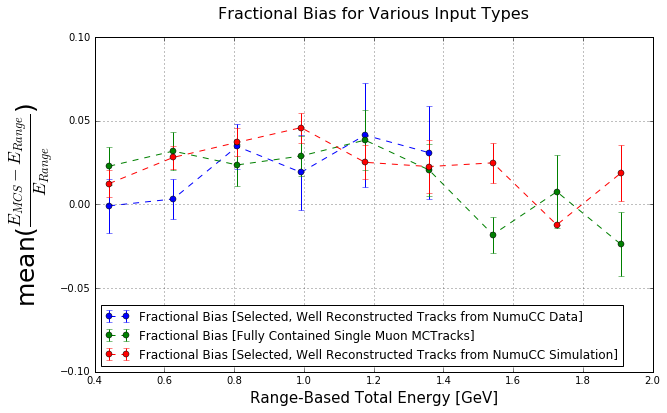

In [7]:
fractional_bias_plots(xvar='full_range_energy',xbins=np.linspace(0.35,2,10))
blah = plt.ylim((-.1,.1))


In [8]:
def fractional_resolution_plots(xvar = 'full_range_energy', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_energy', plot_bin_distributions = False, extraquery = None):

    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
        
    for anatype in anatypes:
     
        myreses, mystds, myerrs = [], [], []
        
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
            
            if anatype == 'singletrack_data': 
                myquery += ' and not maybe_bad'
            if anatype == 'singletrack_MC':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            myerr = mystd / np.sqrt( 2 * float(len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
                
        
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs,fmt='o--',label='Resolution [%s]' % titles[anatype])
    plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('MCS Energy Resolution for Various Input Types',fontsize=16)
    t.set_y(1.04) 

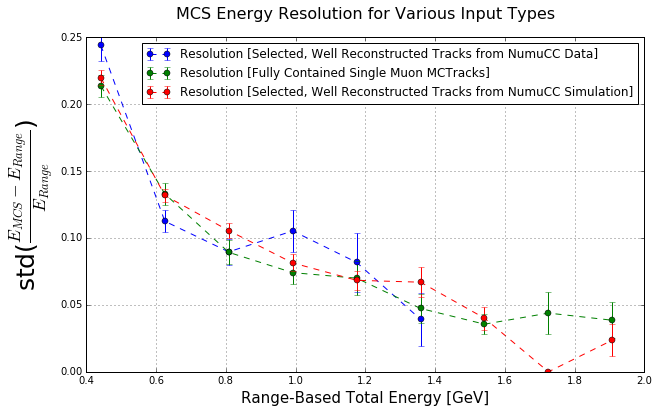

In [9]:
fractional_resolution_plots(xvar='full_range_energy',xbins=np.linspace(0.35,2,10))
blah = plt.ylim((0,0.25))